# Maximum Likelihood Estimation

We will apply the maximum likelihood estimation to try to estimate the original quantum state from measurements. First we will see for pure states, then for mixed states what MLE can bring to Quantum State Tomography for 1 qubit states.

The goal is to reconstruct the original quantum state based on the measurements. Measurements induce statistical noise and the state based on these measurements has no phyical meaning, so we use Maximum Likelihood Estimation to approximate with best fidelity the quantum state it represents.

In [1]:
import numpy as np
import pandas as pd

from scipy.optimize import minimize
import matplotlib.pyplot as plt

## 1. Pure states

A pure state is a quantum state that holds the maximum possible information about a system.  
It can be written as a single vector, not a mix of several states.

For a qubit, a pure state looks like:
|ψ⟩ = α|0⟩ + β|1⟩
with |α|² + |β|² = 1.

The qubit of a pure state is normalized, meaning it touches the border of the Bloch sphere.

In [14]:
df = pd.read_csv("../../data/qst_mle_dataset_purestates.csv")
N_SHOTS = 100  # For each X, Y, Z basis
TOTAL_SHOTS = 300
df.head()

,X_mean,Y_mean,Z_mean,theta_ideal,phi_ideal,cos_phi_ideal,sin_phi_ideal,X_ideal,Y_ideal,Z_ideal
0,0.92,-0.18,-0.28,1.824427,5.973514,0.952434,-0.304745,0.921963,-0.294996,-0.250920
1,-0.56,-0.58,0.06,1.489436,4.005090,-0.649783,-0.760120,-0.647633,-0.757605,0.081270
2,-0.58,0.04,-0.68,2.432155,2.895158,-0.969788,0.243948,-0.631727,0.158909,-0.758728
3,-0.36,0.46,0.56,0.882934,2.147702,-0.545433,0.838155,-0.421404,0.647562,0.634887
4,0.92,-0.06,-0.52,2.040640,6.265118,0.999837,-0.018066,0.891494,-0.016109,-0.452747


### 1.1. Data visualization

Let's take a first look at our dataset.

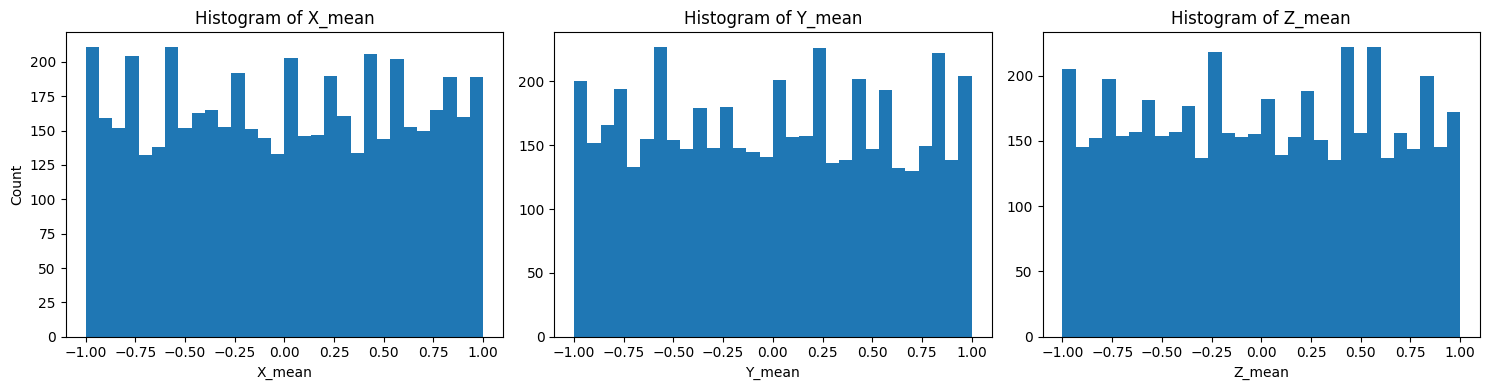

In [15]:
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

axes[0].hist(df["X_mean"], bins=30)
axes[0].set_title("Histogram of X_mean")
axes[0].set_xlabel("X_mean")
axes[0].set_ylabel("Count")

axes[1].hist(df["Y_mean"], bins=30)
axes[1].set_title("Histogram of Y_mean")
axes[1].set_xlabel("Y_mean")

axes[2].hist(df["Z_mean"], bins=30)
axes[2].set_title("Histogram of Z_mean")
axes[2].set_xlabel("Z_mean")

plt.tight_layout()
plt.show()

As we can see, the X_mean, Y_mean and Z_mean are more or less uniformly distributed in our dataset.

In [16]:
# Compute probabilities based on the mean
df["probaX+"] = (1 + df["X_mean"]) / 2.0
df["probaY+"] = (1 + df["Y_mean"]) / 2.0
df["probaZ+"] = (1 + df["Z_mean"]) / 2.0

# Compute number of occurence of each state
# ! We take N_SHOTS = 100 as established before (dataset creation)
df["numberX"] = (df["probaX+"] * N_SHOTS).round().astype(int)
df["numberY"] = (df["probaY+"] * N_SHOTS).round().astype(int)
df["numberZ"] = (df["probaZ+"] * N_SHOTS).round().astype(int)

df.head()

,X_mean,Y_mean,Z_mean,theta_ideal,phi_ideal,cos_phi_ideal,sin_phi_ideal,X_ideal,Y_ideal,Z_ideal,probaX+,probaY+,probaZ+,numberX,numberY,numberZ
0,0.92,-0.18,-0.28,1.824427,5.973514,0.952434,-0.304745,0.921963,-0.294996,-0.250920,0.96,0.41,0.36,96,41,36
1,-0.56,-0.58,0.06,1.489436,4.005090,-0.649783,-0.760120,-0.647633,-0.757605,0.081270,0.22,0.21,0.53,22,21,53
2,-0.58,0.04,-0.68,2.432155,2.895158,-0.969788,0.243948,-0.631727,0.158909,-0.758728,0.21,0.52,0.16,21,52,16
3,-0.36,0.46,0.56,0.882934,2.147702,-0.545433,0.838155,-0.421404,0.647562,0.634887,0.32,0.73,0.78,32,73,78
4,0.92,-0.06,-0.52,2.040640,6.265118,0.999837,-0.018066,0.891494,-0.016109,-0.452747,0.96,0.47,0.24,96,47,24


In [17]:
# General functions
def angles_from_bloch(nx, ny, nz):
    """
    Given Bloch vector (nx, ny, nz) on the sphere, return (theta, phi).
    ! Normalization !
    """
    nx = nx.copy()
    ny = ny.copy()
    nz = nz.copy()
    
    # First we normalize (just in case)
    norm = np.sqrt(nx ** 2 + ny ** 2 + nz ** 2)
    nx /= norm
    ny /= norm
    nz /= norm
    
    # Calculate theta and phi
    theta = np.arccos(nz)
    phi = np.arctan2(ny,nx)
    # Keep phi between 0 and 2pi
    phi = np.where(phi < 0, phi + 2*np.pi, phi)
    return theta, phi

def bloch_from_angles(theta, phi):
    """
    Given (theta, phi), return Bloch vector (nx, ny, nz).
    """
    # Just the normal formula to get the Bloch vector from the angles
    nx = np.sin(theta) * np.cos(phi)
    ny = np.sin(theta) * np.sin(phi)
    nz = np.cos(theta)
    return nx, ny, nz

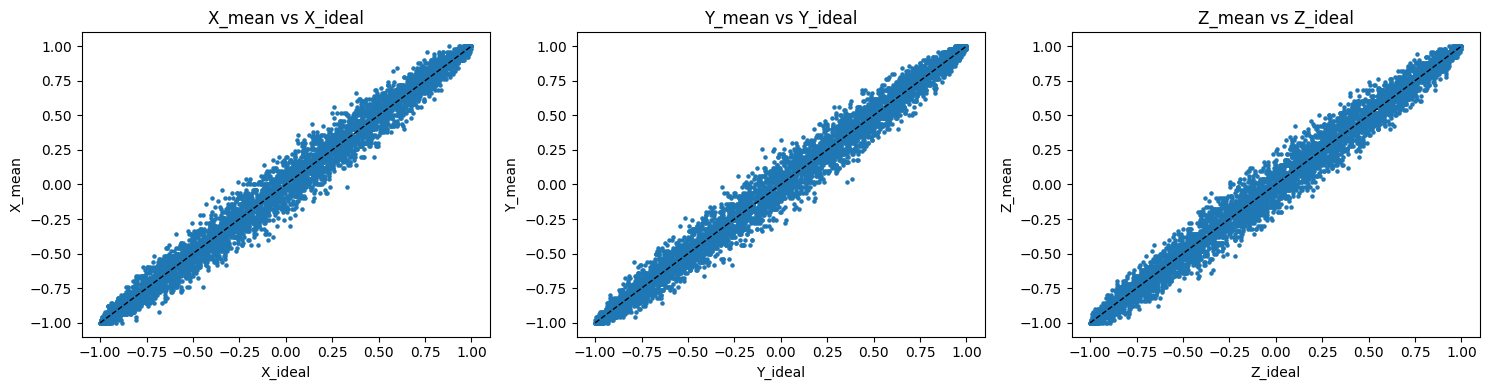

In [18]:
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

axes[0].scatter(df["X_ideal"], df["X_mean"], s=5)
axes[0].plot([-1, 1], [-1, 1], 'k--', linewidth=1)
axes[0].set_title("X_mean vs X_ideal")
axes[0].set_xlabel("X_ideal")
axes[0].set_ylabel("X_mean")

axes[1].scatter(df["Y_ideal"], df["Y_mean"], s=5)
axes[1].plot([-1, 1], [-1, 1], 'k--', linewidth=1)
axes[1].set_title("Y_mean vs Y_ideal")
axes[1].set_xlabel("Y_ideal")
axes[1].set_ylabel("Y_mean")

axes[2].scatter(df["Z_ideal"], df["Z_mean"], s=5)
axes[2].plot([-1, 1], [-1, 1], 'k--', linewidth=1)
axes[2].set_title("Z_mean vs Z_ideal")
axes[2].set_xlabel("Z_ideal")
axes[2].set_ylabel("Z_mean")

plt.tight_layout()
plt.show()

This graph shows us that the X_mean, Y_mean, Z_mean computed from the measurements (we simulated 100 measurement shots of a single state to estimate those parameters) is quite close to the expected means from our 1 qubit state.

Now, we will compare our initial estimation of theta0 and phi0 with the original state to see if we can find any improvement after applying MLE. 

In [ ]:
# Adding some more information in our dataset
# Those are our initial estimation of the qubit, theta0 and phi0
df["theta_measured"], df["phi_measured"] = angles_from_bloch(df["X_mean"], df["Y_mean"], df["Z_mean"])

# Compute the angle error of theta
df["theta_mes_error"] = df["theta_measured"] - df["theta_ideal"]

# Compute the angle error of phi (we must use this formula to ensure the right error as 2pi and 0 are the same)
phi_mes_diff = (df["phi_measured"] - df["phi_ideal"] + np.pi) % (2.0 * np.pi) - np.pi
df["phi_mes_error"] = phi_mes_diff

df.head()

,X_mean,Y_mean,Z_mean,theta_ideal,phi_ideal,cos_phi_ideal,sin_phi_ideal,X_ideal,Y_ideal,Z_ideal,probaX+,probaY+,probaZ+,numberX,numberY,numberZ,theta_measured,phi_measured,theta_mes_error,phi_mes_error
0,0.92,-0.18,-0.28,1.824427,5.973514,0.952434,-0.304745,0.921963,-0.294996,-0.250920,0.96,0.41,0.36,96,41,36,1.861046,6.089974,0.036619,0.116460
1,-0.56,-0.58,0.06,1.489436,4.005090,-0.649783,-0.760120,-0.647633,-0.757605,0.081270,0.22,0.21,0.53,22,21,53,1.496512,3.944533,0.007076,-0.060557
2,-0.58,0.04,-0.68,2.432155,2.895158,-0.969788,0.243948,-0.631727,0.158909,-0.758728,0.21,0.52,0.16,21,52,16,2.434222,3.072736,0.002067,0.177578
3,-0.36,0.46,0.56,0.882934,2.147702,-0.545433,0.838155,-0.421404,0.647562,0.634887,0.32,0.73,0.78,32,73,78,0.806480,2.234842,-0.076454,0.087141
4,0.92,-0.06,-0.52,2.040640,6.265118,0.999837,-0.018066,0.891494,-0.016109,-0.452747,0.96,0.47,0.24,96,47,24,2.084339,6.218060,0.043699,-0.047058


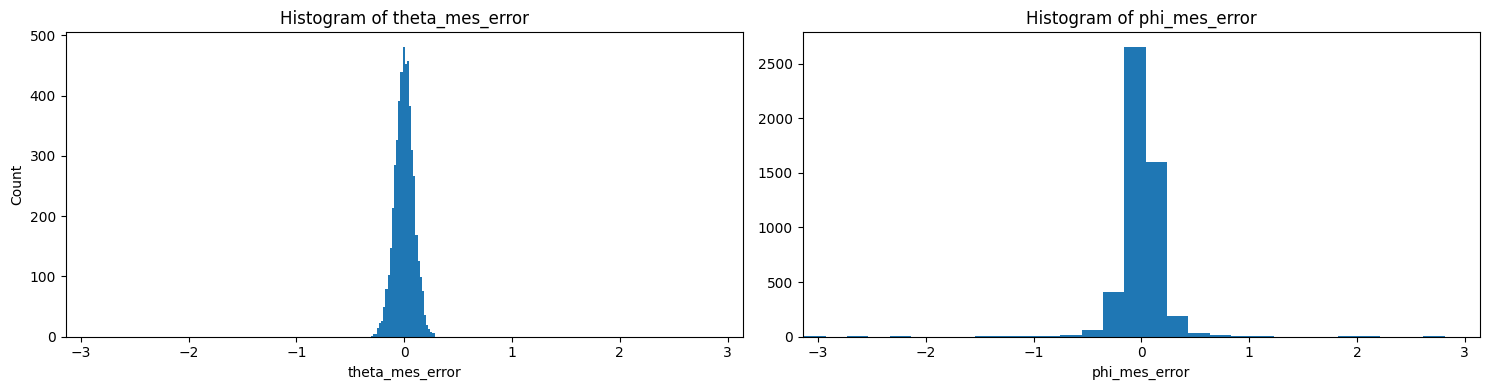

In [23]:
fig, axes = plt.subplots(1, 2, figsize=(15, 4))

axes[0].hist(df["theta_mes_error"], bins=30)
axes[0].set_title("Histogram of theta_mes_error")
axes[0].set_xlabel("theta_mes_error")
axes[0].set_ylabel("Count")
axes[0].set_xlim(-np.pi, np.pi)

axes[1].hist(df["phi_mes_error"], bins=30)
axes[1].set_title("Histogram of phi_mes_error")
axes[1].set_xlabel("phi_mes_error")
axes[1].set_xlim(-np.pi, np.pi)

plt.tight_layout()
plt.show()

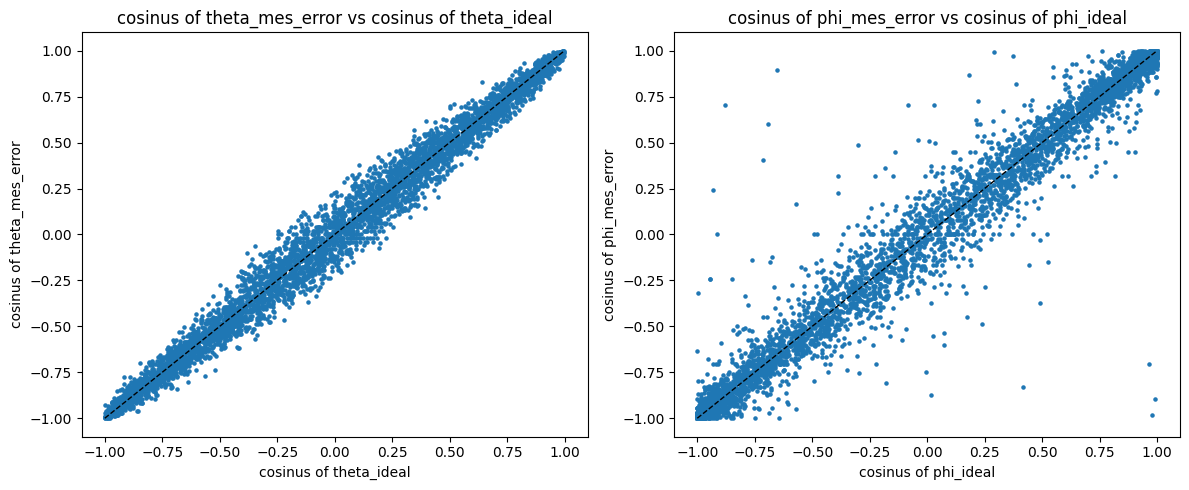

In [61]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# theta
axes[0].scatter(np.cos(df["theta_ideal"]), np.cos(df["theta_measured"]), s=5)
axes[0].plot([-1, 1], [-1, 1], 'k--', linewidth=1)
axes[0].set_title("cosinus of theta_mes_error vs cosinus of theta_ideal")
axes[0].set_xlabel("cosinus of theta_ideal")
axes[0].set_ylabel("cosinus of theta_mes_error")

# phi
axes[1].scatter(df["cos_phi_ideal"], np.cos(df["phi_measured"]), s=5)
axes[1].plot([-1, 1], [-1, 1], 'k--', linewidth=1)
axes[1].set_title("cosinus of phi_mes_error vs cosinus of phi_ideal")
axes[1].set_xlabel("cosinus of phi_ideal")
axes[1].set_ylabel("cosinus of phi_mes_error")

plt.tight_layout()
plt.show()

The left graph shows how off is the theta angle from the measurement with the actual theta angle of the system. The points fall very close to the black diagonal, showing that the estimated values match the true values with already good accuracy. The measurement is quite accurate and stable.

On the other hand, the right graph is much more noisier and the phi angle measured may be way off compared to the actual phi angle. But as we estimated a total of 5000 values, only a few points seem to be way off the diagonal which represent perfectly measured angle, so the majority of the phi angles are still estimated with a good precision.

This difference between the two graphs can be easily explained: this is due to the probabilistic uncertainty of our model. We computed 100 measurements of each state, meaning each mean was computed with 100 values. The theta angle comes directly from the ⟨Z​⟩ expectation value, as we have θ = arccos(Z). The precision of theta is directly linked to the precision of Z_mean. On the other hand, phi is obtained with ϕ = arctan(Y​,X​), so the precision of phi depends on both ⟨X⟩ and ⟨Y⟩.

We will see in the next section the metrics to show how off the measurements are from the actual state of our qubit.

**Metrics:**

In [62]:
nx_true, ny_true, nz_true = bloch_from_angles(df["theta_ideal"], df["phi_ideal"])
nx_mes, ny_mes, nz_mes = bloch_from_angles(df["theta_measured"].values, df["phi_measured"].values)

# Computing fidelity according to the formula
dot_prod_mes = nx_true * nx_mes + ny_true * ny_mes + nz_true * nz_mes
df["fidelity_mes"] = (np.abs(dot_prod_mes) + 1.0) / 2.0
d_mes = np.arccos(dot_prod_mes).mean()

bias_theta_mes = df["theta_mes_error"].mean()
var_theta_mes = df["theta_mes_error"].var(ddof=0) 
mse_theta_mes = ((df["theta_measured"] - df["theta_ideal"]) ** 2).mean()
mae_theta_mes = np.abs(df["theta_measured"] - df["theta_ideal"]).mean()
rmse_theta_mes = np.sqrt(mse_theta_mes)

bias_phi_mes = df["phi_mes_error"].mean()
var_phi_mes = df["phi_mes_error"].var(ddof=0)
mse_phi_mes = (df["phi_mes_error"] ** 2).mean()
mae_phi_mes = np.abs(df["phi_mes_error"]).mean()
rmse_phi_mes = np.sqrt(mse_phi_mes)


In [63]:
print("Mean measured fidelity:", np.mean(df["fidelity_mes"]))
print("Mean distance on the sphere between the actual vector and measured vector: ", d_mes, "\n")

print("Theta (based on first estimation):")
print("Bias:                          ", bias_theta_mes)
print("Variance:                      ", var_theta_mes)
print("Mean square error (MSE):       ", mse_theta_mes)
print("Mean absolute error (MAE):     ", mae_theta_mes)
print("Root mean square error (RMSE): ", rmse_theta_mes, "\n")

print("Phi (based on first estimation):")
print("Bias:                          ", bias_phi_mes)
print("Variance:                      ", var_phi_mes)
print("Mean square error (MSE):       ", mse_phi_mes)
print("Mean absolute error (MAE):     ", mae_phi_mes)
print("Root mean square error (RMSE): ", rmse_phi_mes)

Mean measured fidelity: 0.9959964728642088
Mean distance on the sphere between the actual vector and measured vector:  0.11191120440746197 

Theta (based on first estimation):
Bias:                           -0.0002663887626778136
Variance:                       0.007463238650236431
Mean square error (MSE):        0.007463309613209313
Mean absolute error (MAE):      0.06835710342891438
Root mean square error (RMSE):  0.08639044862257235 

Phi (based on first estimation):
Bias:                           0.002535767495643288
Variance:                       0.036734295249130154
Mean square error (MSE):        0.036740725365922114
Mean absolute error (MAE):      0.11365499858093356
Root mean square error (RMSE):  0.1916787034751699


As we can see, the initial estimation of theta and phi gives us already a very high fidelity with the original vector: we have on average more than 98% fidelity.

The other metrics are less important and just show the statistical errors we got when sampling our quantum states. We must not forget that theta and phi are angles expressed in radian, so every metric is expressed based on the radian unit. For a better visualization, in degrees we have:

In [64]:
print("----- RESULTS IN DEGREE -----")
print("Theta (based on first estimation):")
print("Bias:                          ", 180 / np.pi * bias_theta_mes)
print("Variance:                      ", 180 / np.pi * var_theta_mes)
print("Mean absolute error (MAE):     ", 180 / np.pi * mae_theta_mes)
print("Root mean square error (RMSE): ", 180 / np.pi * rmse_theta_mes, "\n")

print("Phi (based on first estimation):")
print("Bias:                          ", 180 / np.pi * bias_phi_mes)
print("Variance:                      ", 180 / np.pi * var_phi_mes)
print("Mean absolute error (MAE):     ", 180 / np.pi * mae_phi_mes)
print("Root mean square error (RMSE): ", 180 / np.pi * rmse_phi_mes)

----- RESULTS IN DEGREE -----
Theta (based on first estimation):
Bias:                           -0.01526295181115082
Variance:                       0.42761207615746066
Mean absolute error (MAE):      3.916573526216042
Root mean square error (RMSE):  4.949808096315172 

Phi (based on first estimation):
Bias:                           0.14528877532681878
Variance:                       2.104720081162629
Mean absolute error (MAE):      6.511951739252853
Root mean square error (RMSE):  10.982380731666822


As we can see, for both angles the bias is quite low which means that the initial estimation is never over estimating or under estamating the angles.

For theta, the MAE and RMSE are quite close, meaning that the error is on average around 4° and data with strong error is generally around 5°. There is - or very few - data very far off, which coincide with the graph from before.

Phi is a bit different as, first, the average error is bigger with around 6.5°, and the RMSE is almost twice the MAE, meaning there are some data with a very strong error.

We will see if MLE can reduce those statistical errors.

### 1.2. Applying the algorithm

Now we will apply the MLE algorithm.

In [ ]:
# Functions for the MLE algorithm
def neg_log_likelihood(params, row):
    theta, phi = params # Parameters to optimize
    
    # Get the components of the estimated Bloch vector based on theta and phi (variables)
    nx, ny, nz = bloch_from_angles(theta, phi) 
    
    # New estimated probabilities 
    px_plus = (1.0 + nx) / 2.0
    py_plus = (1.0 + ny) / 2.0
    pz_plus = (1.0 + nz) / 2.0
    
    # Just to be sure to avoid log(0)
    eps = 1e-12
    px_plus = np.clip(px_plus, eps, 1.0 - eps)
    py_plus = np.clip(py_plus, eps, 1.0 - eps)
    pz_plus = np.clip(pz_plus, eps, 1.0 - eps)
    
    # Negative log likelihood formula
    nllx = -(df.iloc[row]["numberX"] * np.log(px_plus) + 
             (N_SHOTS - df.iloc[row]["numberX"]) * np.log(1 - px_plus))
    nlly = -(df.iloc[row]["numberY"] * np.log(py_plus) + 
             (N_SHOTS - df.iloc[row]["numberY"]) * np.log(1 - py_plus))
    nllz = -(df.iloc[row]["numberZ"] * np.log(pz_plus) + 
             (N_SHOTS - df.iloc[row]["numberZ"]) * np.log(1 - pz_plus))
    
    return nllx + nlly + nllz

def mle_row(row):
    # First estimation of theta and phi (based on the mean)
    theta0, phi0 = df.iloc[row]["theta_measured"], df.iloc[row]["phi_measured"]
    
    # Keep theta between 0 and pi and phi between 0 and 2pi
    bounds = [(0.0, np.pi), (0.0, 2.0 * np.pi)]
    
    # Minimize the Negative Log Likelihood
    res = minimize(
        fun=neg_log_likelihood,
        x0=np.array([theta0, phi0], dtype=float),
        args=(row,),
        bounds=bounds,
        method="L-BFGS-B"
    )
    
    theta_hat, phi_hat = res.x
    # In case phi = 2pi we bring it back to 0
    phi_hat = phi_hat % (2.0 * np.pi)
    
    return theta_hat, phi_hat

In [66]:
theta_hats = []
phi_hats = []

# Apply the algorithm to every state. It takes around 1 minute to run
for i in range(len(df)):
    theta_hat, phi_hat = mle_row(i)
    theta_hats.append(theta_hat)
    phi_hats.append(phi_hat)

### 1.3. Looking at the metrics and comparing

In [71]:
df["theta_hat"] = theta_hats
df["phi_hat"] = phi_hats

df["X_predicted"], df["Y_predicted"], df["Z_predicted"] = bloch_from_angles(df["theta_hat"], df["phi_hat"])
df["probaX+_pred"] = (1 + df["X_predicted"]) / 2.0
df["probaY+_pred"] = (1 + df["Y_predicted"]) / 2.0
df["probaZ+_pred"] = (1 + df["Z_predicted"]) / 2.0

# Compute the angle error of theta
df["theta_error"] = df["theta_hat"] - df["theta_ideal"]

# Compute the angle error of phi (we must use this formula to ensure the right error as 2pi and 0 are the same)
phi_diff = (df["phi_hat"] - df["phi_ideal"] + np.pi) % (2.0 * np.pi) - np.pi
df["phi_error"] = phi_diff

In [72]:
# Computing MLL (Mean log likelihood)
df["Mean_ll"] = (df["numberX"] * np.log(df["probaX+_pred"]) + 
                 (N_SHOTS - df["numberX"]) * np.log(1.0 - df["probaX+_pred"]) + 
                 df["numberY"] * np.log(df["probaY+_pred"]) + 
                 (N_SHOTS - df["numberY"]) * np.log(1.0 - df["probaY+_pred"]) + 
                 df["numberZ"] * np.log(df["probaZ+_pred"]) + 
                 (N_SHOTS - df["numberZ"]) * np.log(1.0 - df["probaZ+_pred"])) / N_SHOTS

mean_logL_per_shot = df["Mean_ll"].sum() / TOTAL_SHOTS
mean_logL_per_state =df["Mean_ll"].mean()

# Cross entropy, KL divergence, Fisher information à ajouter

In [75]:
nx_hat, ny_hat, nz_hat = bloch_from_angles(df["theta_hat"], df["phi_hat"])

# Computing fidelity according to the formula
# Using nx_true, ny_true and nz_true from the vector calculated in the previous section
dot_prod = nx_true * nx_hat + ny_true * ny_hat + nz_true * nz_hat
df["fidelity"] = (np.abs(dot_prod) + 1.0) / 2.0
d = np.arccos(dot_prod).mean()

bias_theta = df["theta_error"].mean()
var_theta = df["theta_error"].var(ddof=0) 
mse_theta = ((df["theta_error"]) ** 2).mean()
mae_theta = np.abs(df["theta_error"]).mean()
rmse_theta = np.sqrt(mse_theta)

bias_phi = df["phi_error"].mean()
var_phi = df["phi_error"].var(ddof=0)
mse_phi = (df["phi_error"] ** 2).mean()
mae_phi = np.abs(df["phi_error"]).mean()
rmse_phi = np.sqrt(mse_phi)

In [76]:
print("Mean fidelity:", np.mean(df["fidelity"]))
print("Mean distance on the sphere between the actual vector and estimated vector: ", d, "\n")

print("Theta (after MLE):")
print("Bias:                          ", bias_theta)
print("Variance:                      ", var_theta)
print("Mean square error (MSE):       ", mse_theta)
print("Mean absolute error (MAE):     ", mae_theta)
print("Root mean square error (RMSE): ", rmse_theta, "\n")

print("Phi (after MLE):")
print("Bias:                          ", bias_phi)
print("Variance:                      ", var_phi)
print("Mean square error (MSE):       ", mse_phi)
print("Mean absolute error (MAE):     ", mae_phi)
print("Root mean square error (RMSE): ", rmse_phi)

Mean fidelity: 0.996274170440226
Mean distance on the sphere between the actual vector and estimated vector:  0.10733463224399707 

Theta (after MLE):
Bias:                           0.00029874516278745436
Variance:                       0.006671416285436465
Mean square error (MSE):        0.006671505534108752
Mean absolute error (MAE):      0.06417529197695954
Root mean square error (RMSE):  0.08167928460820865 

Phi (after MLE):
Bias:                           0.0033114257776212953
Variance:                       0.03640224901970218
Mean square error (MSE):        0.03641321456038287
Mean absolute error (MAE):      0.11187034538708297
Root mean square error (RMSE):  0.19082246869900535


As we can see, with MLE estimation we can get an even better estimation of the Bloch vector than from the initial estimation, with on average more than 98.5% fidelity.

Let's convert everything in degree and compare with the first estimation the measured data:

In [77]:
print("----- ESTIMATED METRICS -----")
print("Theta (after MLE):")
print("Bias:                          ", 180 / np.pi * bias_theta)
print("Variance:                      ", 180 / np.pi * var_theta)
print("Mean absolute error (MAE):     ", 180 / np.pi * mae_theta)
print("Root mean square error (RMSE): ", 180 / np.pi * rmse_theta, "\n")

print("Phi (after MLE):")
print("Bias:                          ", 180 / np.pi * bias_phi)
print("Variance:                      ", 180 / np.pi * var_phi)
print("Mean absolute error (MAE):     ", 180 / np.pi * mae_phi)
print("Root mean square error (RMSE): ", 180 / np.pi * rmse_phi)

print("\n")
print("----- MEASURED METRICS -----")
print("Theta (based on first estimation):")
print("Bias:                          ", 180 / np.pi * bias_theta_mes)
print("Variance:                      ", 180 / np.pi * var_theta_mes)
print("Mean absolute error (MAE):     ", 180 / np.pi * mae_theta_mes)
print("Root mean square error (RMSE): ", 180 / np.pi * rmse_theta_mes, "\n")

print("Phi (based on first estimation):")
print("Bias:                          ", 180 / np.pi * bias_phi_mes)
print("Variance:                      ", 180 / np.pi * var_phi_mes)
print("Mean absolute error (MAE):     ", 180 / np.pi * mae_phi_mes)
print("Root mean square error (RMSE): ", 180 / np.pi * rmse_phi_mes)
# À COMPLETER POUR PHI

----- ESTIMATED METRICS -----
Theta (after MLE):
Bias:                           0.017116836977669872
Variance:                       0.38224399653035435
Mean absolute error (MAE):      3.6769733792995547
Root mean square error (RMSE):  4.679878281698222 

Phi (after MLE):
Bias:                           0.1897307212285269
Variance:                       2.0856952336131735
Mean absolute error (MAE):      6.409698643350672
Root mean square error (RMSE):  10.933322092720264


----- MEASURED METRICS -----
Theta (based on first estimation):
Bias:                           -0.01526295181115082
Variance:                       0.42761207615746066
Mean absolute error (MAE):      3.916573526216042
Root mean square error (RMSE):  4.949808096315172 

Phi (based on first estimation):
Bias:                           0.14528877532681878
Variance:                       2.104720081162629
Mean absolute error (MAE):      6.511951739252853
Root mean square error (RMSE):  10.982380731666822


After applying MLE, we can see that we have a little improvement on our reconstruction of the angles of the original states. On average, Variance, MSE, MAE and RMSE are a little bit lower. But this is still very shallow as the improvement is around 0.1° in average, which is very low. The bias doesn't really change and is still very close to 0.

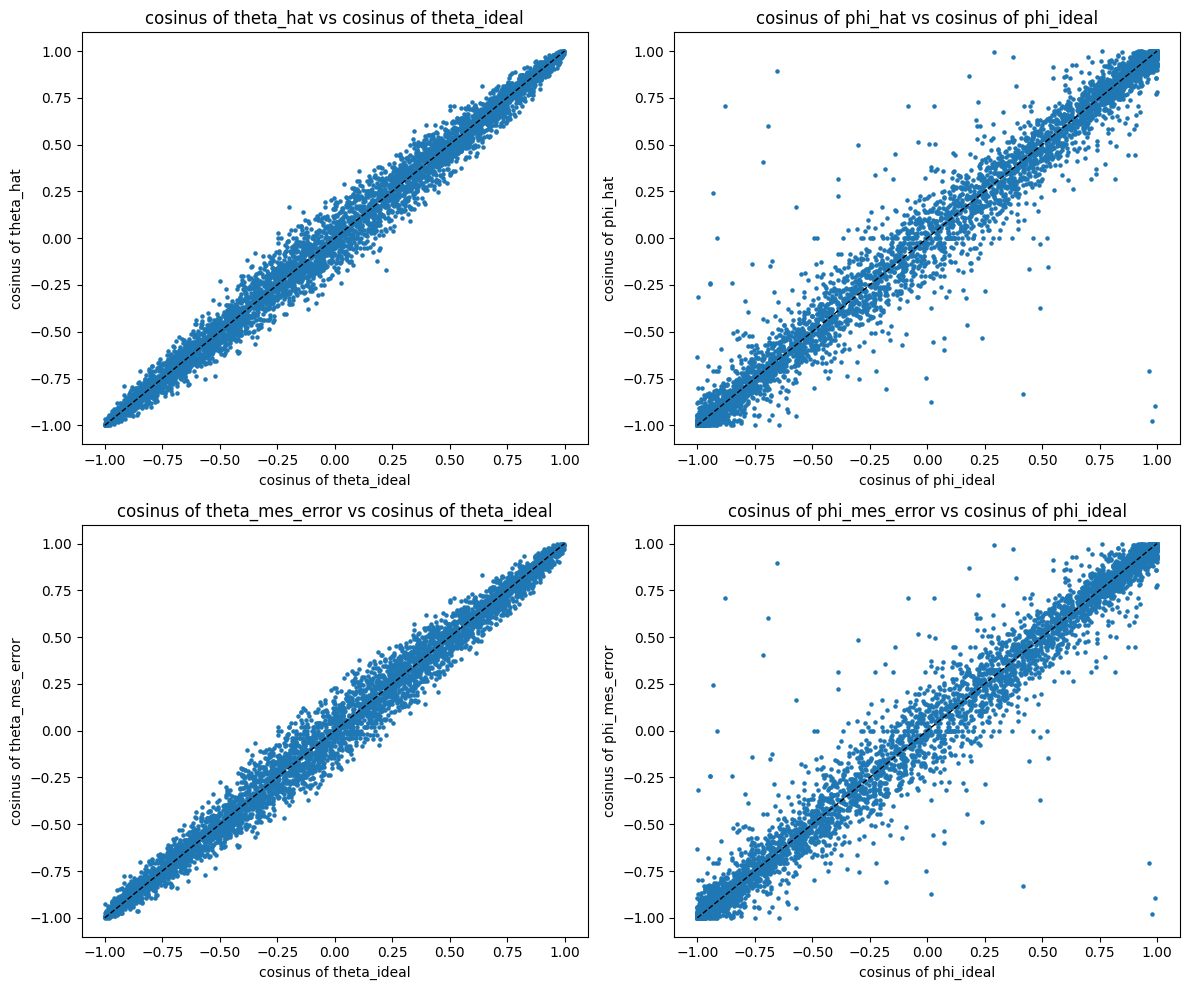

In [78]:
# Displaying results
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# theta
axes[0,0].scatter(np.cos(df["theta_ideal"]), np.cos(df["theta_hat"]), s=5)
axes[0,0].plot([-1, 1], [-1, 1], 'k--', linewidth=1)
axes[0,0].set_title("cosinus of theta_hat vs cosinus of theta_ideal")
axes[0,0].set_xlabel("cosinus of theta_ideal")
axes[0,0].set_ylabel("cosinus of theta_hat")

# phi
axes[0,1].scatter(df["cos_phi_ideal"], np.cos(df["phi_hat"]), s=5)
axes[0,1].plot([-1, 1], [-1, 1], 'k--', linewidth=1)
axes[0,1].set_title("cosinus of phi_hat vs cosinus of phi_ideal")
axes[0,1].set_xlabel("cosinus of phi_ideal")
axes[0,1].set_ylabel("cosinus of phi_hat")

# theta
axes[1,0].scatter(np.cos(df["theta_ideal"]), np.cos(df["theta_measured"]), s=5)
axes[1,0].plot([-1, 1], [-1, 1], 'k--', linewidth=1)
axes[1,0].set_title("cosinus of theta_mes_error vs cosinus of theta_ideal")
axes[1,0].set_xlabel("cosinus of theta_ideal")
axes[1,0].set_ylabel("cosinus of theta_mes_error")

# phi
axes[1,1].scatter(df["cos_phi_ideal"], np.cos(df["phi_measured"]), s=5)
axes[1,1].plot([-1, 1], [-1, 1], 'k--', linewidth=1)
axes[1,1].set_title("cosinus of phi_mes_error vs cosinus of phi_ideal")
axes[1,1].set_xlabel("cosinus of phi_ideal")
axes[1,1].set_ylabel("cosinus of phi_mes_error")

plt.tight_layout()
plt.show()

Here we can compare the results of the cosine of both angles before and after applying MLE. The first row is the same as the data displayed in the previous section, where we can how off are the measured angles (initial estimation) compared to the original angle of our measured state.

On the second row, this is the same cosine of the initial angle compared this time with the cosine of the estimated angle with MLE. As we can see, both rows are very similar, which coincide with the idea that MLE did not provide a very clear improvement on the guess of the angles compared to the initial estimation.

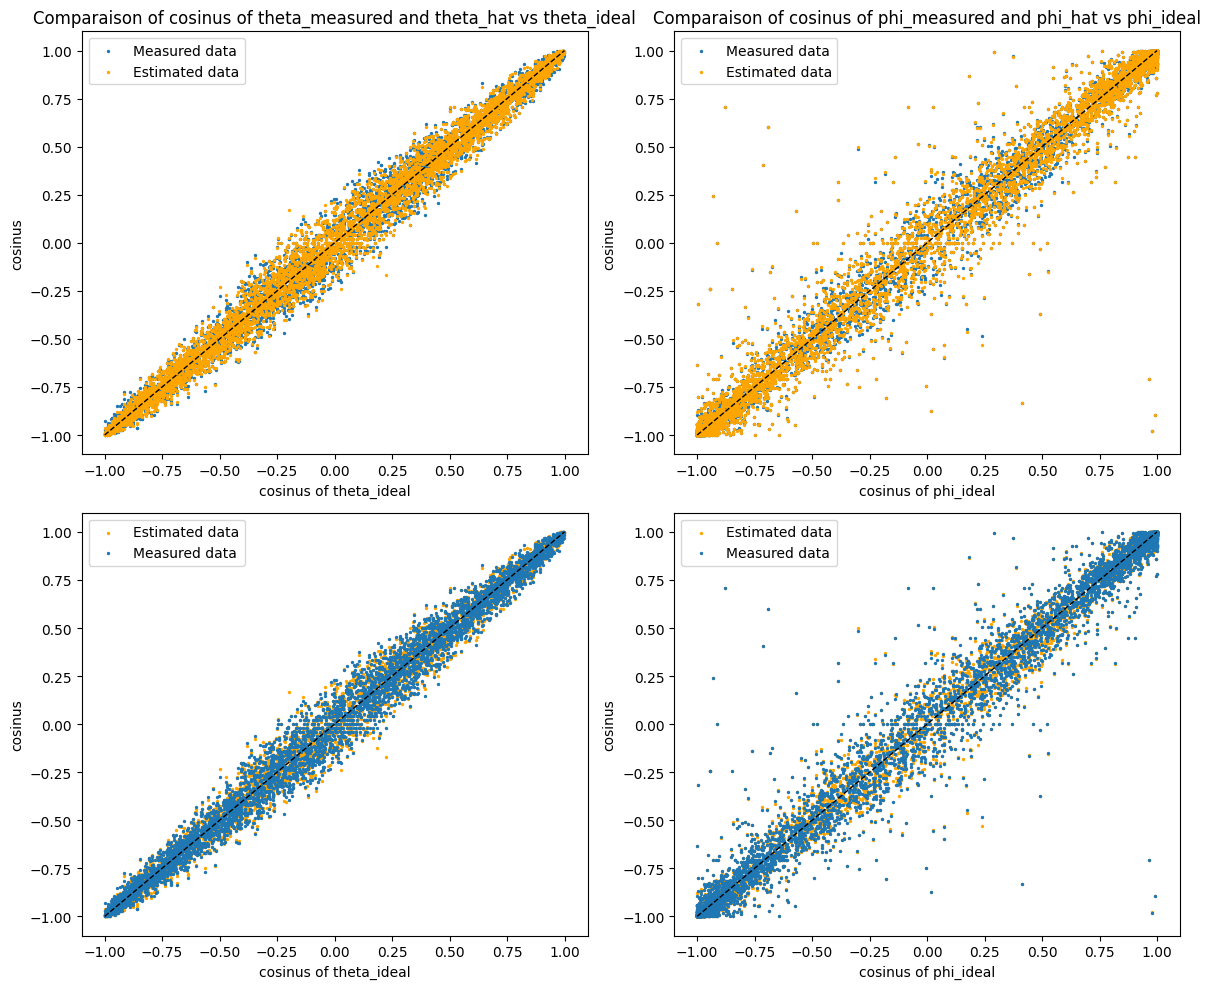

In [79]:
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# theta
axes[0,0].scatter(np.cos(df["theta_ideal"]), np.cos(df["theta_measured"]), s=2, label="Measured data")
axes[0,0].scatter(np.cos(df["theta_ideal"]), np.cos(df["theta_hat"]), s=2, color="orange", label="Estimated data")
axes[0,0].plot([-1, 1], [-1, 1], 'k--', linewidth=1)
axes[0,0].set_title("Comparaison of cosinus of theta_measured and theta_hat vs theta_ideal")
axes[0,0].set_xlabel("cosinus of theta_ideal")
axes[0,0].set_ylabel("cosinus")

# phi
axes[0,1].scatter(df["cos_phi_ideal"], np.cos(df["phi_measured"]), s=2, label="Measured data")
axes[0,1].scatter(df["cos_phi_ideal"], np.cos(df["phi_hat"]), s=2, color="orange", label="Estimated data")
axes[0,1].plot([-1, 1], [-1, 1], 'k--', linewidth=1)
axes[0,1].set_title("Comparaison of cosinus of phi_measured and phi_hat vs phi_ideal")
axes[0,1].set_xlabel("cosinus of phi_ideal")
axes[0,1].set_ylabel("cosinus")

axes[0,0].legend()
axes[0,1].legend()


# theta
axes[1,0].scatter(np.cos(df["theta_ideal"]), np.cos(df["theta_hat"]), s=2, color="orange", label="Estimated data")
axes[1,0].scatter(np.cos(df["theta_ideal"]), np.cos(df["theta_measured"]), s=2, label="Measured data")
axes[1,0].plot([-1, 1], [-1, 1], 'k--', linewidth=1)
axes[1,0].set_xlabel("cosinus of theta_ideal")
axes[1,0].set_ylabel("cosinus")

# phi
axes[1,1].scatter(df["cos_phi_ideal"], np.cos(df["phi_hat"]), s=2, color="orange", label="Estimated data")
axes[1,1].scatter(df["cos_phi_ideal"], np.cos(df["phi_measured"]), s=2, label="Measured data")
axes[1,1].plot([-1, 1], [-1, 1], 'k--', linewidth=1)
axes[1,1].set_xlabel("cosinus of phi_ideal")
axes[1,1].set_ylabel("cosinus")

axes[1,1].legend()
axes[1,0].legend()


plt.tight_layout()
plt.show()

Here we are displaying the same data but this time we have both initial estimated angles and measured angles in two different colors, to see what are the actual differences of the graphs displayed just before. The color superposition is then inverted to see if we can make any conclusion from those graphs. 

We can faintly see for the theta angle that the estimated angle (orange) is overall a little bit closer to the black diagonal line, meaning better results. In the first graph the blue dots seem to be more on the edge of the orange cloud as on the second graph the orange dots seem more inside of the blue cloud.

For the phi angle, no real conclusion can be made.

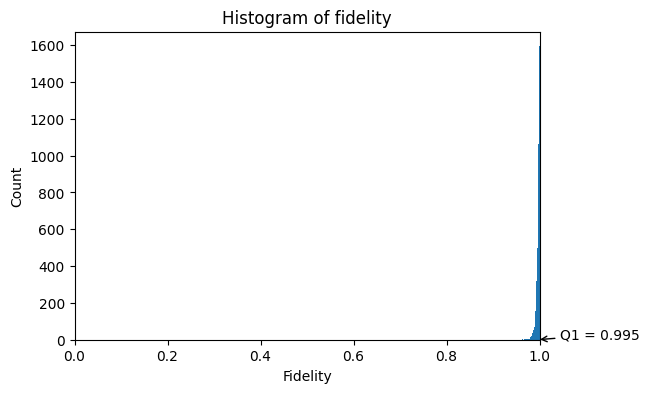

In [115]:
q1 = df["fidelity"].quantile(0.25)

plt.figure(figsize=(6, 4))
plt.hist(df["fidelity"], bins=30)
plt.annotate(f"Q1 = {q1:.3f}", xy=(q1, 0), xytext=(q1+0.05, 5),
             arrowprops=dict(arrowstyle="->"))
plt.title("Histogram of fidelity")
plt.xlabel("Fidelity")
plt.ylabel("Count")
plt.xlim(0, 1)

plt.show()


This is the fidelity of every predicted state. As we can see the fidelity is for most states very close to one, and is in vast majority greater than 95%. The first quantile is at 99.5%, meaning three quarter of the fidelities are above this number.

### 1.4. Testing on other datasets

We can really see how usefull MLE is when the initial angle estimation is far from the real angle value.

In [35]:
# Loading dataset with only 30 measurements per state (compared to 300 before)
df_unb = pd.read_csv("../../data/qst_mle_dataset_purestates_unbalanced_outside_poles.csv")
N_SHOTS_unb = 10  # For each X, Y, Z basis
TOTAL_SHOTS_unb = 30
df_unb.head()

,X_mean,Y_mean,Z_mean,theta_ideal,phi_ideal,cos_phi_ideal,sin_phi_ideal,cos_theta_ideal,sin_theta_ideal,X_ideal,Y_ideal,Z_ideal
0,1.0,0.2,0.4,1.520612,5.973514,0.952434,-0.304745,0.050163,0.998741,0.951235,-0.304362,0.050163
1,1.0,-0.4,0.4,1.396817,5.962024,0.948869,-0.315669,0.173103,0.984904,0.934545,-0.310904,0.173103
2,-0.8,0.4,-0.4,1.483170,3.409860,-0.964232,-0.265061,0.087514,0.996163,-0.960532,-0.264044,0.087514
3,-0.6,0.2,-0.2,1.579889,2.686319,-0.898141,0.439708,-0.009093,0.999959,-0.898104,0.439690,-0.009093
4,-1.0,0.2,0.0,1.373577,3.209120,-0.997721,-0.067476,0.195943,0.980615,-0.978380,-0.066168,0.195943


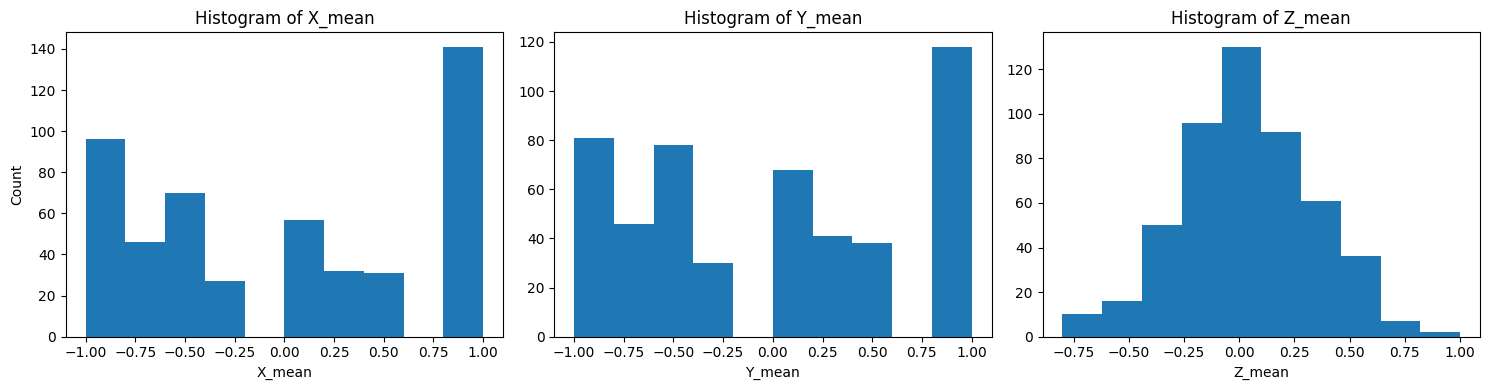

In [36]:
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

axes[0].hist(df_unb["X_mean"], bins=10)
axes[0].set_title("Histogram of X_mean")
axes[0].set_xlabel("X_mean")
axes[0].set_ylabel("Count")

axes[1].hist(df_unb["Y_mean"], bins=10)
axes[1].set_title("Histogram of Y_mean")
axes[1].set_xlabel("Y_mean")

axes[2].hist(df_unb["Z_mean"], bins=10)
axes[2].set_title("Histogram of Z_mean")
axes[2].set_xlabel("Z_mean")

plt.tight_layout()
plt.show()

In [37]:
# Compute probabilities based on the mean
df_unb["probaX+"] = (1 + df_unb["X_mean"]) / 2.0
df_unb["probaY+"] = (1 + df_unb["Y_mean"]) / 2.0
df_unb["probaZ+"] = (1 + df_unb["Z_mean"]) / 2.0

# Compute number of occurence of each state
# ! We take N_SHOTS_unb = 20 as established before (dataset creation)
df_unb["numberX"] = (df_unb["probaX+"] * N_SHOTS_unb).round().astype(int)
df_unb["numberY"] = (df_unb["probaY+"] * N_SHOTS_unb).round().astype(int)
df_unb["numberZ"] = (df_unb["probaZ+"] * N_SHOTS_unb).round().astype(int)

df_unb.head()

,X_mean,Y_mean,Z_mean,theta_ideal,phi_ideal,cos_phi_ideal,sin_phi_ideal,cos_theta_ideal,sin_theta_ideal,X_ideal,Y_ideal,Z_ideal,probaX+,probaY+,probaZ+,numberX,numberY,numberZ
0,1.0,0.2,0.4,1.520612,5.973514,0.952434,-0.304745,0.050163,0.998741,0.951235,-0.304362,0.050163,1.0,0.6,0.7,10,6,7
1,1.0,-0.4,0.4,1.396817,5.962024,0.948869,-0.315669,0.173103,0.984904,0.934545,-0.310904,0.173103,1.0,0.3,0.7,10,3,7
2,-0.8,0.4,-0.4,1.483170,3.409860,-0.964232,-0.265061,0.087514,0.996163,-0.960532,-0.264044,0.087514,0.1,0.7,0.3,1,7,3
3,-0.6,0.2,-0.2,1.579889,2.686319,-0.898141,0.439708,-0.009093,0.999959,-0.898104,0.439690,-0.009093,0.2,0.6,0.4,2,6,4
4,-1.0,0.2,0.0,1.373577,3.209120,-0.997721,-0.067476,0.195943,0.980615,-0.978380,-0.066168,0.195943,0.0,0.6,0.5,0,6,5


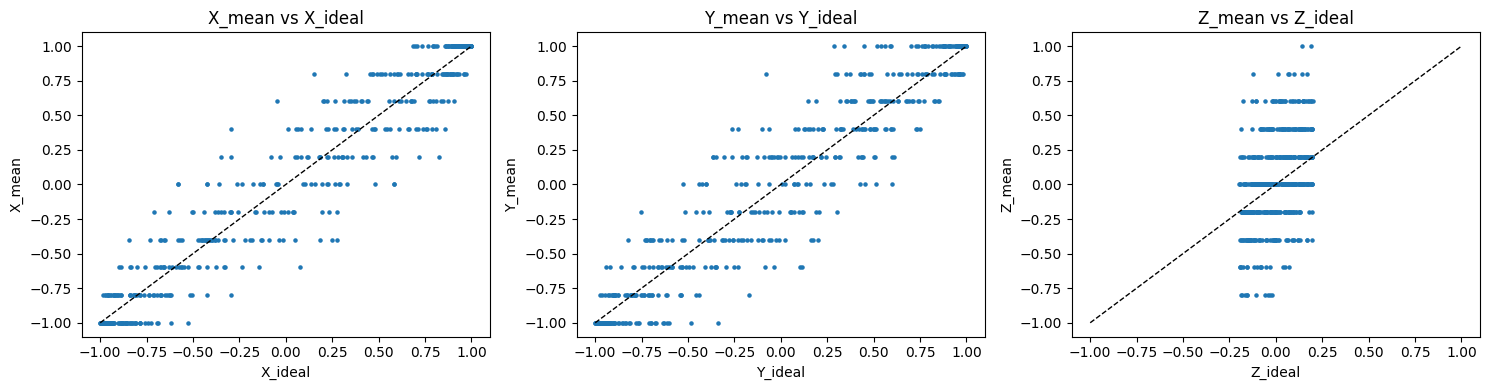

In [38]:
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

axes[0].scatter(df_unb["X_ideal"], df_unb["X_mean"], s=5)
axes[0].plot([-1, 1], [-1, 1], 'k--', linewidth=1)
axes[0].set_title("X_mean vs X_ideal")
axes[0].set_xlabel("X_ideal")
axes[0].set_ylabel("X_mean")

axes[1].scatter(df_unb["Y_ideal"], df_unb["Y_mean"], s=5)
axes[1].plot([-1, 1], [-1, 1], 'k--', linewidth=1)
axes[1].set_title("Y_mean vs Y_ideal")
axes[1].set_xlabel("Y_ideal")
axes[1].set_ylabel("Y_mean")

axes[2].scatter(df_unb["Z_ideal"], df_unb["Z_mean"], s=5)
axes[2].plot([-1, 1], [-1, 1], 'k--', linewidth=1)
axes[2].set_title("Z_mean vs Z_ideal")
axes[2].set_xlabel("Z_ideal")
axes[2].set_ylabel("Z_mean")

plt.tight_layout()
plt.show()

In [39]:
# Adding some more information in our dataset
# Those are our initial estimation of the qubit, theta0 and phi0
df_unb["theta_measured"], df_unb["phi_measured"] = angles_from_bloch(df_unb["X_mean"], df_unb["Y_mean"], df_unb["Z_mean"])

# Compute the angle error of theta
df_unb["theta_mes_error"] = df_unb["theta_measured"] - df_unb["theta_ideal"]

# Compute the angle error of phi (we must use this formula to ensure the right error as 2pi and 0 are the same)
phi_mes_diff = (df_unb["phi_measured"] - df_unb["phi_ideal"] + 
                np.pi) % (2.0 * np.pi) - np.pi
df_unb["phi_mes_error"] = phi_mes_diff

df_unb.head()

,X_mean,Y_mean,Z_mean,theta_ideal,phi_ideal,cos_phi_ideal,sin_phi_ideal,cos_theta_ideal,sin_theta_ideal,X_ideal,...,probaX+,probaY+,probaZ+,numberX,numberY,numberZ,theta_measured,phi_measured,theta_mes_error,phi_mes_error
0,1.0,0.2,0.4,1.520612,5.973514,0.952434,-0.304745,0.050163,0.998741,0.951235,...,1.0,0.6,0.7,10,6,7,1.197004,0.197396,-0.323608,0.507067
1,1.0,-0.4,0.4,1.396817,5.962024,0.948869,-0.315669,0.173103,0.984904,0.934545,...,1.0,0.3,0.7,10,3,7,1.215194,5.902679,-0.181623,-0.059345
2,-0.8,0.4,-0.4,1.483170,3.409860,-0.964232,-0.265061,0.087514,0.996163,-0.960532,...,0.1,0.7,0.3,1,7,3,1.991331,2.677945,0.508161,-0.731915
3,-0.6,0.2,-0.2,1.579889,2.686319,-0.898141,0.439708,-0.009093,0.999959,-0.898104,...,0.2,0.6,0.4,2,6,4,1.877074,2.819842,0.297184,0.133523
4,-1.0,0.2,0.0,1.373577,3.209120,-0.997721,-0.067476,0.195943,0.980615,-0.978380,...,0.0,0.6,0.5,0,6,5,1.570796,2.944197,0.197219,-0.264923


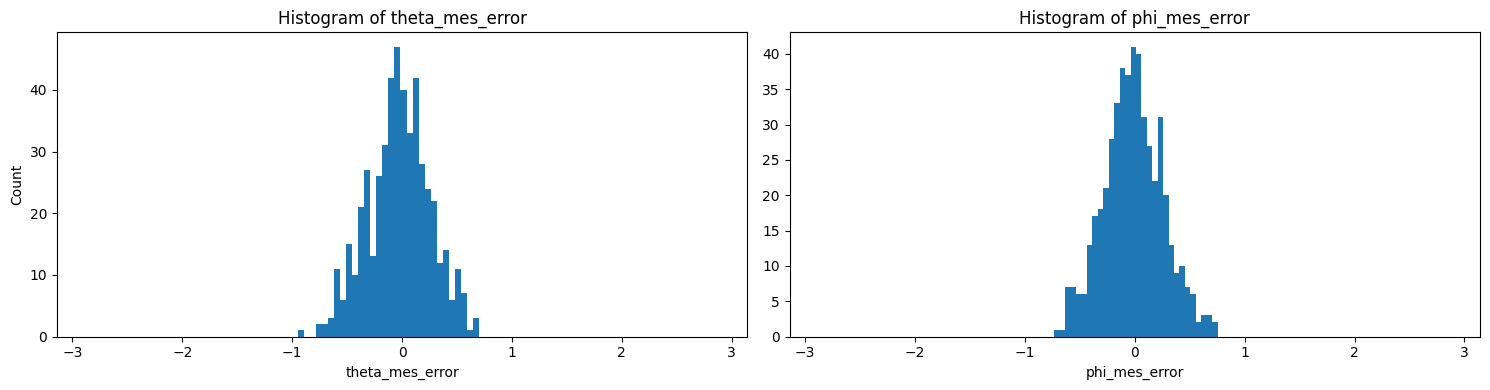

In [40]:
fig, axes = plt.subplots(1, 2, figsize=(15, 4))

axes[0].hist(df_unb["theta_mes_error"], bins=30)
axes[0].set_title("Histogram of theta_mes_error")
axes[0].set_xlabel("theta_mes_error")
axes[0].set_ylabel("Count")
axes[0].set_xlim(-np.pi, np.pi)

axes[1].hist(df_unb["phi_mes_error"], bins=30)
axes[1].set_title("Histogram of phi_mes_error")
axes[1].set_xlabel("phi_mes_error")
axes[1].set_xlim(-np.pi, np.pi)

plt.tight_layout()
plt.show()

In [41]:
nx_true_unb, ny_true_unb, nz_true_unb = bloch_from_angles(df_unb["theta_ideal"], df_unb["phi_ideal"])
nx_mes_unb, ny_mes_unb, nz_mes_unb = bloch_from_angles(df_unb["theta_measured"], df_unb["phi_measured"])

# Computing fidelity according to the formula
dot_prod_mes_unb = nx_true_unb * nx_mes_unb + ny_true_unb * ny_mes_unb + nz_true_unb * nz_mes_unb
df_unb["fidelity_mes"] = (np.abs(dot_prod_mes_unb) + 1.0) / 2.0
d_mes_unb = np.arccos(dot_prod_mes_unb).mean()

print("Mean measured fidelity:", np.mean(df_unb["fidelity_mes"]))
print("Mean distance on the sphere between the actual vector and measured vector: ", d_mes_unb, "\n")

Mean measured fidelity: 0.9633499540975032
Mean distance on the sphere between the actual vector and measured vector:  0.3432199102102384 



In [42]:
# Functions for the MLE algorithm
def neg_log_likelihood_unb(params, row):
    theta, phi = params # Parameters to optimize
    
    # Get the components of the estimated Bloch vector based on theta and phi (variables)
    nx, ny, nz = bloch_from_angles(theta, phi) 
    
    # New estimated probabilities 
    px_plus = (1.0 + nx) / 2.0
    py_plus = (1.0 + ny) / 2.0
    pz_plus = (1.0 + nz) / 2.0
    
    # Just to be sure to avoid log(0)
    eps = 1e-12
    px_plus = np.clip(px_plus, eps, 1.0 - eps)
    py_plus = np.clip(py_plus, eps, 1.0 - eps)
    pz_plus = np.clip(pz_plus, eps, 1.0 - eps)
    
    # Negative log likelihood formula
    nllx = -(df_unb.iloc[row]["numberX"] * np.log(px_plus) + 
             (N_SHOTS_unb - df_unb.iloc[row]["numberX"]) * np.log(1 - px_plus))
    nlly = -(df_unb.iloc[row]["numberY"] * np.log(py_plus) + 
             (N_SHOTS_unb - df_unb.iloc[row]["numberY"]) * np.log(1 - py_plus))
    nllz = -(df_unb.iloc[row]["numberZ"] * np.log(pz_plus) + 
             (N_SHOTS_unb - df_unb.iloc[row]["numberZ"]) * np.log(1 - pz_plus))
    
    return nllx + nlly + nllz

def mle_row_unb(row):
    # First estimation of theta and phi (based on the mean)
    theta0, phi0 = df_unb.iloc[row]["theta_measured"], df_unb.iloc[row]["phi_measured"]
    
    # Keep theta between 0 and pi and phi between 0 and 2pi
    bounds = [(0.0, np.pi), (0.0, 2.0 * np.pi)]
    
    # Minimize the Negative Log Likelihood
    res = minimize(
        fun=neg_log_likelihood_unb,
        x0=np.array([theta0, phi0], dtype=float),
        args=(row,),
        bounds=bounds,
        method="L-BFGS-B"
    )
    
    theta_hat, phi_hat = res.x
    # In case phi = 2pi we bring it back to 0
    phi_hat = phi_hat % (2.0 * np.pi)
    
    return theta_hat, phi_hat

In [43]:
theta_hats_unb = []
phi_hats_unb = []

# Apply the algorithm to every state. It takes around 8sec to run
for i in range(len(df_unb)):
    theta_hat, phi_hat = mle_row_unb(i)
    theta_hats_unb.append(theta_hat)
    phi_hats_unb.append(phi_hat)

df_unb["theta_hat"] = theta_hats_unb
df_unb["phi_hat"] = phi_hats_unb

df_unb.head()

,X_mean,Y_mean,Z_mean,theta_ideal,phi_ideal,cos_phi_ideal,sin_phi_ideal,cos_theta_ideal,sin_theta_ideal,X_ideal,...,numberX,numberY,numberZ,theta_measured,phi_measured,theta_mes_error,phi_mes_error,fidelity_mes,theta_hat,phi_hat
0,1.0,0.2,0.4,1.520612,5.973514,0.952434,-0.304745,0.050163,0.998741,0.951235,...,10,6,7,1.197004,0.197396,-0.323608,0.507067,0.915551,1.300423,0.136367
1,1.0,-0.4,0.4,1.396817,5.962024,0.948869,-0.315669,0.173103,0.984904,0.934545,...,10,3,7,1.215194,5.902679,-0.181623,-0.059345,0.990963,1.304514,6.006925
2,-0.8,0.4,-0.4,1.483170,3.409860,-0.964232,-0.265061,0.087514,0.996163,-0.960532,...,1,7,3,1.991331,2.677945,0.508161,-0.731915,0.820374,1.997251,2.669965
3,-0.6,0.2,-0.2,1.579889,2.686319,-0.898141,0.439708,-0.009093,0.999959,-0.898104,...,2,6,4,1.877074,2.819842,0.297184,0.133523,0.973839,2.015867,2.644364
4,-1.0,0.2,0.0,1.373577,3.209120,-0.997721,-0.067476,0.195943,0.980615,-0.978380,...,0,6,5,1.570796,2.944197,0.197219,-0.264923,0.973202,1.570796,3.007659


In [44]:
# Compute the angle error of theta
df_unb["theta_error"] = df_unb["theta_hat"] - df_unb["theta_ideal"]

# Compute the angle error of phi (we must use this formula to ensure the right error as 2pi and 0 are the same)
phi_diff = (df_unb["phi_hat"] - df_unb["phi_ideal"] + np.pi) % (2.0 * np.pi) - np.pi
df_unb["phi_error"] = phi_diff

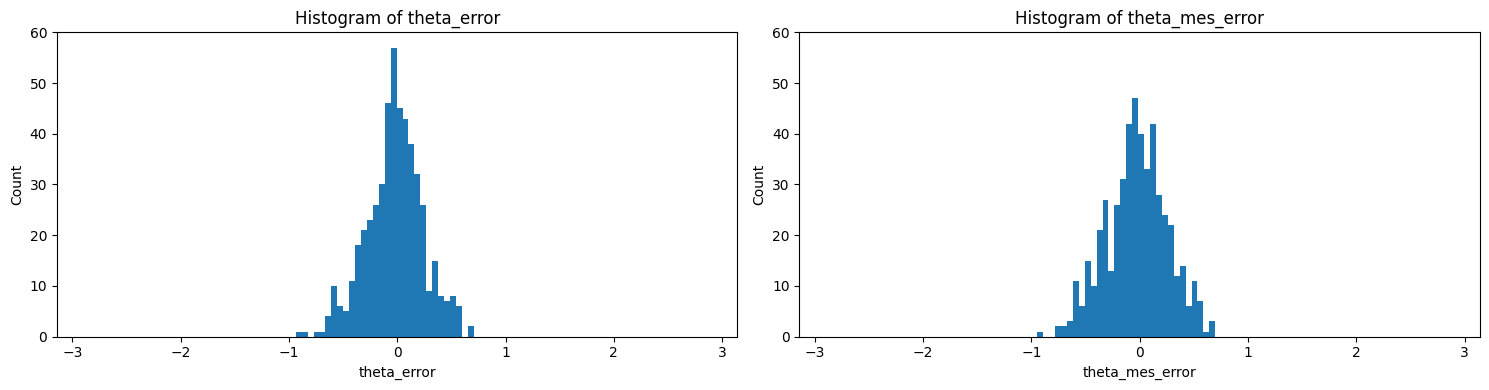

In [47]:
fig, axes = plt.subplots(1, 2, figsize=(15, 4))

axes[0].hist(df_unb["theta_error"], bins=30)
axes[0].set_title("Histogram of theta_error")
axes[0].set_xlabel("theta_error")
axes[0].set_ylabel("Count")
axes[0].set_xlim(-np.pi, np.pi)
axes[0].set_ylim(0, 60)

axes[1].hist(df_unb["theta_mes_error"], bins=30)
axes[1].set_title("Histogram of theta_mes_error")
axes[1].set_xlabel("theta_mes_error")
axes[1].set_ylabel("Count")
axes[1].set_xlim(-np.pi, np.pi)
axes[1].set_ylim(0, 60)

plt.tight_layout()
plt.show()

In [112]:
nx_hat_unb, ny_hat_unb, nz_hat_unb = bloch_from_angles(df_unb["theta_hat"], df_unb["phi_hat"])

# Computing fidelity according to the formula
# Using nx_true, ny_true and nz_true from the vector calculated in the previous section
dot_prod_unb = nx_true_unb * nx_hat_unb + ny_true_unb * ny_hat_unb + nz_true_unb * nz_hat_unb
df_unb["fidelity"] = (np.abs(dot_prod_unb) + 1.0) / 2.0
d_unb = np.arccos(dot_prod_unb).mean()

print("Mean fidelity:", np.mean(df_unb["fidelity"]))
print("Mean distance on the sphere between the actual vector and estimated vector: ", d_unb, "\n")

Mean fidelity: 0.9767958347204805
Mean distance on the sphere between the actual vector and estimated vector:  0.2705945154342229 



## Mixed stated

In [11]:
df_ms = pd.read_csv("../../data/qst_mle_dataset_mixed_states.csv")
N_SHOTS_ms = 100  # For each X, Y, Z basis
TOTAL_SHOTS_ms = 300

df_ms = df_ms[df_ms["r_ideal"] >= 0.001]
df_ms.head()

,X_mean,Y_mean,Z_mean,theta_ideal,phi_ideal,r_ideal,cos_phi_ideal,sin_phi_ideal,cos_theta_ideal,sin_theta_ideal,X_ideal,Y_ideal,Z_ideal
0,0.00,-0.92,-0.28,1.824427,4.599254,0.950714,-0.112894,-0.993607,-0.250920,0.968008,-0.103896,-0.914415,-0.238553
1,0.72,-0.18,0.18,1.292352,6.131459,0.726091,0.988512,-0.151144,0.274860,0.961484,0.690105,-0.105518,0.199573
2,-0.12,-0.18,-0.08,2.198555,3.163064,0.364270,-0.999769,-0.021470,-0.587333,0.809346,-0.294752,-0.006330,-0.213948
3,-0.10,0.40,-0.30,1.813796,1.684294,0.590295,-0.113254,0.993566,-0.240615,0.970621,-0.064889,0.569266,-0.142034
4,-0.16,-0.54,-0.58,2.308719,4.358534,0.794810,-0.346517,-0.938044,-0.672752,0.739868,-0.203770,-0.551620,-0.534710


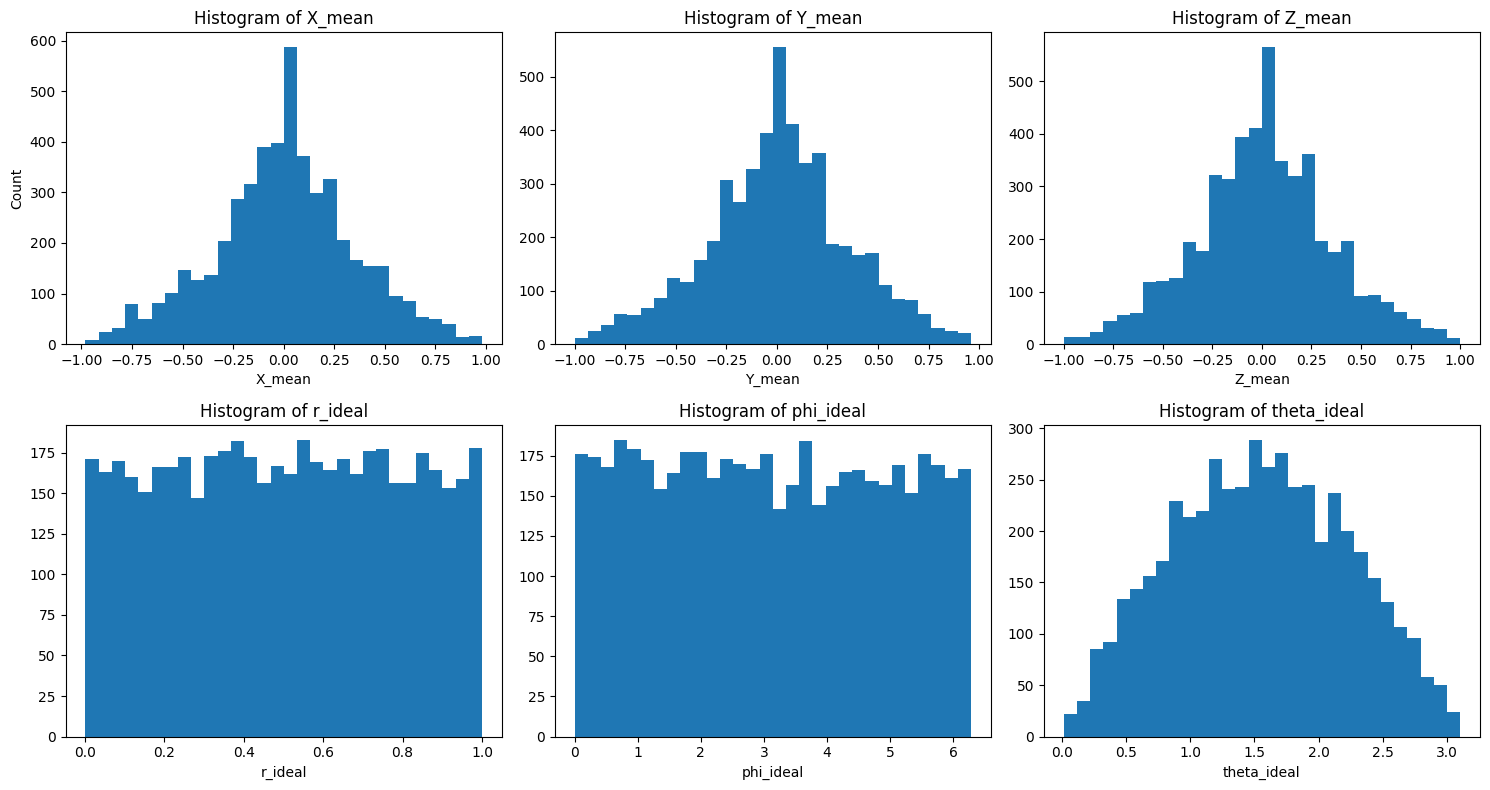

In [12]:
fig, axes = plt.subplots(2, 3, figsize=(15, 8))

axes[0,0].hist(df_ms["X_mean"], bins=30)
axes[0,0].set_title("Histogram of X_mean")
axes[0,0].set_xlabel("X_mean")
axes[0,0].set_ylabel("Count")

axes[0,1].hist(df_ms["Y_mean"], bins=30)
axes[0,1].set_title("Histogram of Y_mean")
axes[0,1].set_xlabel("Y_mean")

axes[0,2].hist(df_ms["Z_mean"], bins=30)
axes[0,2].set_title("Histogram of Z_mean")
axes[0,2].set_xlabel("Z_mean")

axes[1,0].hist(df_ms["r_ideal"], bins=30)
axes[1,0].set_title("Histogram of r_ideal")
axes[1,0].set_xlabel("r_ideal")

axes[1,1].hist(df_ms["phi_ideal"], bins=30)
axes[1,1].set_title("Histogram of phi_ideal")
axes[1,1].set_xlabel("phi_ideal")

axes[1,2].hist(df_ms["theta_ideal"], bins=30)
axes[1,2].set_title("Histogram of theta_ideal")
axes[1,2].set_xlabel("theta_ideal")

plt.tight_layout()
plt.show()

In [13]:
# Compute probabilities based on the mean
df_ms["probaX+"] = (1 + df_ms["X_mean"]) / 2.0
df_ms["probaY+"] = (1 + df_ms["Y_mean"]) / 2.0
df_ms["probaZ+"] = (1 + df_ms["Z_mean"]) / 2.0

# Compute number of occurence of each state
# ! We take N_SHOTS = 100 as established before (dataset creation)
df_ms["numberX"] = (df_ms["probaX+"] * N_SHOTS_ms).round().astype(int)
df_ms["numberY"] = (df_ms["probaY+"] * N_SHOTS_ms).round().astype(int)
df_ms["numberZ"] = (df_ms["probaZ+"] * N_SHOTS_ms).round().astype(int)

df_ms["rx"] = 2 * df_ms["probaX+"] - 1 
df_ms["ry"] = 2 * df_ms["probaY+"] - 1 
df_ms["rz"] = 2 * df_ms["probaZ+"] - 1 

df_ms["r0"] = np.minimum(1, np.sqrt(df_ms["rx"] ** 2 + df_ms["ry"] ** 2 + df_ms["rz"] ** 2))
df_ms["theta0"] = np.arccos(df_ms["rz"] / df_ms["r0"])
df_ms["phi0"] = np.arctan2(df_ms["ry"], df_ms["rx"]) % (2 * np.pi)

df_ms.head()

,X_mean,Y_mean,Z_mean,theta_ideal,phi_ideal,r_ideal,cos_phi_ideal,sin_phi_ideal,cos_theta_ideal,sin_theta_ideal,...,probaZ+,numberX,numberY,numberZ,rx,ry,rz,r0,theta0,phi0
0,0.00,-0.92,-0.28,1.824427,4.599254,0.950714,-0.112894,-0.993607,-0.250920,0.968008,...,0.36,50,4,36,0.00,-0.92,-0.28,0.961665,1.866237,4.712389
1,0.72,-0.18,0.18,1.292352,6.131459,0.726091,0.988512,-0.151144,0.274860,0.961484,...,0.59,86,41,59,0.72,-0.18,0.18,0.763675,1.332855,6.038207
2,-0.12,-0.18,-0.08,2.198555,3.163064,0.364270,-0.999769,-0.021470,-0.587333,0.809346,...,0.46,44,41,46,-0.12,-0.18,-0.08,0.230651,1.925000,4.124386
3,-0.10,0.40,-0.30,1.813796,1.684294,0.590295,-0.113254,0.993566,-0.240615,0.970621,...,0.35,45,70,35,-0.10,0.40,-0.30,0.509902,2.199811,1.815775
4,-0.16,-0.54,-0.58,2.308719,4.358534,0.794810,-0.346517,-0.938044,-0.672752,0.739868,...,0.21,42,23,21,-0.16,-0.54,-0.58,0.808455,2.370884,4.424334


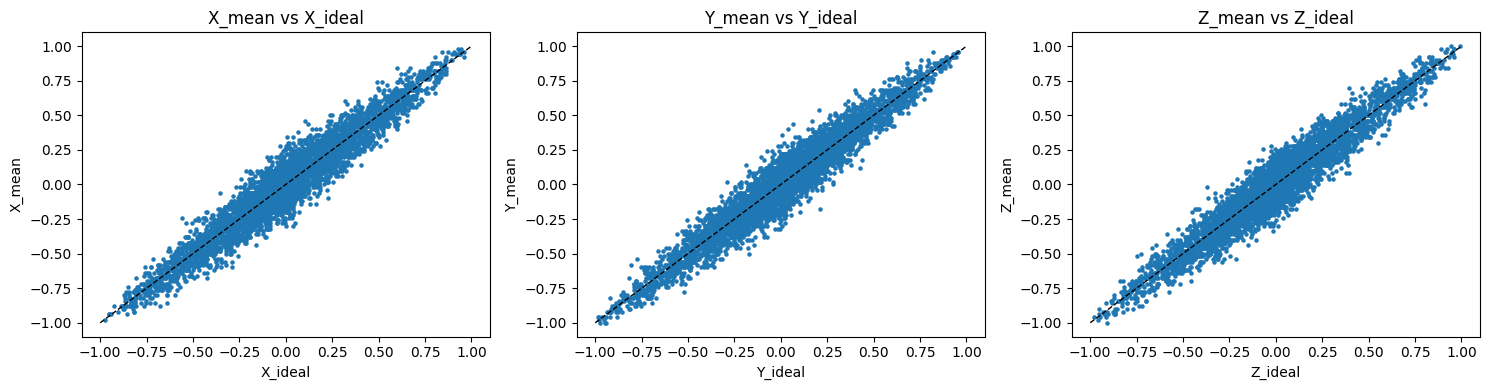

In [14]:
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

axes[0].scatter(df_ms["X_ideal"], df_ms["X_mean"], s=5)
axes[0].plot([-1, 1], [-1, 1], 'k--', linewidth=1)
axes[0].set_title("X_mean vs X_ideal")
axes[0].set_xlabel("X_ideal")
axes[0].set_ylabel("X_mean")

axes[1].scatter(df_ms["Y_ideal"], df_ms["Y_mean"], s=5)
axes[1].plot([-1, 1], [-1, 1], 'k--', linewidth=1)
axes[1].set_title("Y_mean vs Y_ideal")
axes[1].set_xlabel("Y_ideal")
axes[1].set_ylabel("Y_mean")

axes[2].scatter(df_ms["Z_ideal"], df_ms["Z_mean"], s=5)
axes[2].plot([-1, 1], [-1, 1], 'k--', linewidth=1)
axes[2].set_title("Z_mean vs Z_ideal")
axes[2].set_xlabel("Z_ideal")
axes[2].set_ylabel("Z_mean")

plt.tight_layout()
plt.show()

In [15]:
# Vecteur de Bloch pour l'état estimé
df_ms["rx0"] = df_ms["r0"] * np.sin(df_ms["theta0"]) * np.cos(df_ms["phi0"])
df_ms["ry0"] = df_ms["r0"] * np.sin(df_ms["theta0"]) * np.sin(df_ms["phi0"])
df_ms["rz0"] = df_ms["r0"] * np.cos(df_ms["theta0"])

# Vecteur de Bloch pour l'état idéal 
df_ms["rx_id"] = df_ms["r_ideal"] * np.sin(df_ms["theta_ideal"]) * np.cos(df_ms["phi_ideal"])
df_ms["ry_id"] = df_ms["r_ideal"] * np.sin(df_ms["theta_ideal"]) * np.sin(df_ms["phi_ideal"])
df_ms["rz_id"] = df_ms["r_ideal"] * np.cos(df_ms["theta_ideal"])

# Produit scalaire r0 · r_ideal
dot = (
    df_ms["rx0"] * df_ms["rx_id"]
    + df_ms["ry0"] * df_ms["ry_id"]
    + df_ms["rz0"] * df_ms["rz_id"]
)

r0_sq = df_ms["r0"]**2
r_id_sq = df_ms["r_ideal"]**2

# Terme racine (gérer les arrondis numériques avec clip)
sqrt_term = np.sqrt(
    np.clip(1 - r0_sq, 0, 1) * np.clip(1 - r_id_sq, 0, 1)
)

df_ms["fidelity_mes"] = 0.5 * (1 + dot + sqrt_term)

# Sécurité numé­rique
df_ms["fidelity_mes"] = np.clip(df_ms["fidelity_mes"], 0, 1)

print("Mean measured fidelity:", np.mean(df_ms["fidelity_mes"]))

Mean measured fidelity: 0.9910511818997462


In [20]:
# Compte le nombre d'états où l'estimation linéaire donnait un rayon > 1
nb_erreurs_physiques = len(df_ms[df_ms['r0'] > 1.0])
print(f"Nombre d'états initialement non-physiques : {nb_erreurs_physiques} sur {len(df_ms)}")

Nombre d'états initialement non-physiques : 0 sur 4997


In [16]:
def neg_log_likelihood_ms(params, row):
    theta, phi, r = params

    # Bloch vector direction
    rx = np.sin(theta) * np.cos(phi)
    ry = np.sin(theta) * np.sin(phi)
    rz = np.cos(theta)

    # Expected Pauli means
    Ex = r * rx
    Ey = r * ry
    Ez = r * rz

    # Theoretical probabilities for + outcome
    Px = 0.5 * (1 + Ex)
    Py = 0.5 * (1 + Ey)
    Pz = 0.5 * (1 + Ez)

    # Clip numerical instabilities (strict MLE domain)
    eps = 1e-12
    Px = np.clip(Px, eps, 1 - eps)
    Py = np.clip(Py, eps, 1 - eps)
    Pz = np.clip(Pz, eps, 1 - eps)

    # Observations
    kx = df_ms.iloc[row]["numberX"]
    ky = df_ms.iloc[row]["numberY"]
    kz = df_ms.iloc[row]["numberZ"]

    # Binomial negative log-likelihood (sans constantes)
    nll  = -( kx * np.log(Px) + (N_SHOTS_ms - kx) * np.log(1 - Px) )
    nll += -( ky * np.log(Py) + (N_SHOTS_ms - ky) * np.log(1 - Py) )
    nll += -( kz * np.log(Pz) + (N_SHOTS_ms - kz) * np.log(1 - Pz) )

    return nll

def mle_row_ms(row):
    # First estimation of theta and phi (based on the mean)
    theta0, phi0, r0 = df_ms.iloc[row]["theta0"], df_ms.iloc[row]["phi0"], df_ms.iloc[row]["r0"]
    
    # Keep theta between 0 and pi and phi between 0 and 2pi
    bounds = [(0.0, np.pi), (-np.pi, 3.0 * np.pi), (0.001, 1.0)]
    
    # Minimize the Negative Log Likelihood
    res = minimize(
        fun=neg_log_likelihood_ms,
        x0=np.array([theta0, phi0, r0], dtype=float),
        args=(row,),
        bounds=bounds,
        method="L-BFGS-B"
    )
    
    theta_hat, phi_hat, r_hat = res.x
    # In case phi = 2pi we bring it back to 0
    phi_hat = phi_hat % (2.0 * np.pi)
    
    return theta_hat, phi_hat, r_hat

In [17]:
theta_hats_ms = []
phi_hats_ms = []
r_hats_ms = []

# Apply the algorithm to every state. It takes around 1 minute to run
for i in range(len(df_ms)):
    theta_hat, phi_hat, r_hat = mle_row_ms(i)
    theta_hats_ms.append(theta_hat)
    phi_hats_ms.append(phi_hat)
    r_hats_ms.append(r_hat)

In [ ]:
df_ms["theta_hat"] = theta_hats_ms
df_ms["phi_hat"] = phi_hats_ms  
df_ms["r_hat"] = r_hats_ms

df_ms[["r_ideal", "r0", "r_hat", "phi_ideal", "phi0", "phi_hat", "theta_ideal", "theta0", "theta_hat"]].head()

,r_ideal,r0,r_hat,phi_ideal,phi0,phi_hat,theta_ideal,theta0,theta_hat
0,0.950714,0.961665,0.961665,4.599254,4.712389,4.712389,1.824427,1.866237,1.866237
1,0.726091,0.763675,0.763675,6.131459,6.038207,6.038207,1.292352,1.332855,1.332855
2,0.364270,0.230651,0.230651,3.163064,4.124386,4.124386,2.198555,1.925000,1.925000
3,0.590295,0.509902,0.509902,1.684294,1.815775,1.815775,1.813796,2.199811,2.199811
4,0.794810,0.808455,0.808455,4.358534,4.424334,4.424334,2.308719,2.370884,2.370884


In [19]:
# Vecteur de Bloch pour l'état estimé
df_ms["rx_hat"] = df_ms["r_hat"] * np.sin(df_ms["theta_hat"]) * np.cos(df_ms["phi_hat"])
df_ms["ry_hat"] = df_ms["r_hat"] * np.sin(df_ms["theta_hat"]) * np.sin(df_ms["phi_hat"])
df_ms["rz_hat"] = df_ms["r_hat"] * np.cos(df_ms["theta_hat"])

# Produit scalaire r0 · r_ideal
dot_mle = (
    df_ms["rx_hat"] * df_ms["rx_id"]
    + df_ms["ry_hat"] * df_ms["ry_id"]
    + df_ms["rz_hat"] * df_ms["rz_id"]
)

r0_sq_mle = df_ms["r_hat"]**2
r_id_sq_mle = df_ms["r_ideal"]**2

# Terme racine (gérer les arrondis numériques avec clip)
sqrt_term_mle = np.sqrt(
    np.clip(1 - r0_sq_mle, 0, 1) * np.clip(1 - r_id_sq_mle, 0, 1)
)

df_ms["fidelity"] = 0.5 * (1 + dot_mle + sqrt_term_mle)

# Sécurité numé­rique
df_ms["fidelity"] = np.clip(df_ms["fidelity"], 0, 1)

print("Mean fidelity:", np.mean(df_ms["fidelity"]))

Mean fidelity: 0.9910725720184344
